# Resume Screening - Applicant Tracking System (ATS)

Henry Yost, Riya Ashok, Angelina Jordan, Gokul Giridharan, and Refugio Zepeda Jr

## Project Outline
> Answer

## Dataset Exploration & Variables in the Dataset
> Answer more in depth

Given a dataset of resumes, can we assess if someone is qualified for the job position?

### Plan

1. Use BERT to classify the categories into 'buckets'
2. Save each bucket as a new CSV file
3. For the CSV file most closely related, find a very specific Job Description (i.e., Software Engineer @ Apple)
4. Preprocess resumes (lowercasing, removing symbols, indents, etc)
5. Use RegEx and hard criteria to filter resumes (Phase 1)
6. Pick an IDEAL resume for the position (let's say the person is leaving, and use their resume as the ideal one to fill in the position)
7. TF-IDF on applicants' resume and ideal --> Cosine similarity, Rank in order
8. Human looks through the top 20 resumes and marks as qualified or not
9. Use resume BERT embeddings for logistical regression
10. Naive Bayes with TF-IDF?
11. Lastly, combine via Soft voting, rank fusion or stacking (not sure which one would work best)

In [23]:
# Library Importing
import pandas as pd
import re #RegEx
!pip install -U -q sentence-transformers

# First stage resume cleaning
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

## 1. Importing Dataset & Cleaning

In [8]:
df_orig = pd.read_csv("Resume.csv")
df_orig = df_orig.drop("Resume_html", axis=1) # Drop HTML, because we do not need it

# All possible categories: HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, 
# Healthcare, Fitness, Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, 
# Finance, Apparel, Engineering, Accountant, Construction, Public Relations, Banking, Arts, Aviation

# Separate into approx 5 meaningful buckets
df_tech = df_orig[df_orig['Category'].isin(['INFORMATION-TECHNOLOGY', 'ENGINEERING', 'DIGITAL-MEDIA', 'HR'])]
df_tech = df_tech.copy()
df_health_well = df_orig[df_orig['Category'].isin(['HEALTHCARE', 'FITNESS'])]
df_bus_fin = df_orig[df_orig['Category'].isin(['BUSINESS-DEVELOPMENT', 'SALES', 'CONSULTANT', 'FINANCE', 'ACCOUNTANT', 'BANKING'])]
df_creative_public = df_orig[df_orig['Category'].isin(['ARTS', 'DESIGNER', 'PUBLIC-RELATIONS', 'TEACHER', 'ADVOCATE', 'APPAREL'])]
df_indust = df_orig[df_orig['Category'].isin(['AGRICULTURE', 'AUTOMOBILE', 'CONSTRUCTION', 'AVIATION', 'BPO', 'CHEF'])]

# Write each bucket to a CSV
df_tech.to_csv("tech.csv")
df_health_well.to_csv("health_wellness.csv")
df_bus_fin.to_csv("business_finance.csv")
df_creative_public.to_csv("creative_public.csv")
df_indust.to_csv("industrial.csv")

In [9]:
# Using RegEx to clean the Resume strings
def clean_resume(text):
    text = text.lower() # Make everything lowercase.
    text = re.sub(r'\s+', ' ', text) # replaces whitespace characters with a single space.
    text = re.sub(r'\/+', ' ', text) # replaces / characters with a single space (some resumes use backslashes)
    text = re.sub(r'[^a-z0-9\s\.\,\-]', '', text) # keeps letters, numbers, whitespace, periods, and dashes.
    text = re.sub(r'\s+', ' ', text).strip() # replaces leading and trailing whitespace characters.
    return text

df_tech.loc[:, "Cleaned_str"] = df_tech["Resume_str"].apply(clean_resume)

# Also, there are no NaN values, so we don't need to drop any rows.

df_tech.head()

,ID,Resume_str,Category,Cleaned_str
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,"hr specialist, us hr operations summary versat..."
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary over 20 years experience i...
3,27018550,HR SPECIALIST Summary Dedica...,HR,"hr specialist summary dedicated, driven, and d..."
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...


## 4. Exploratory Data Analysis (EDA)

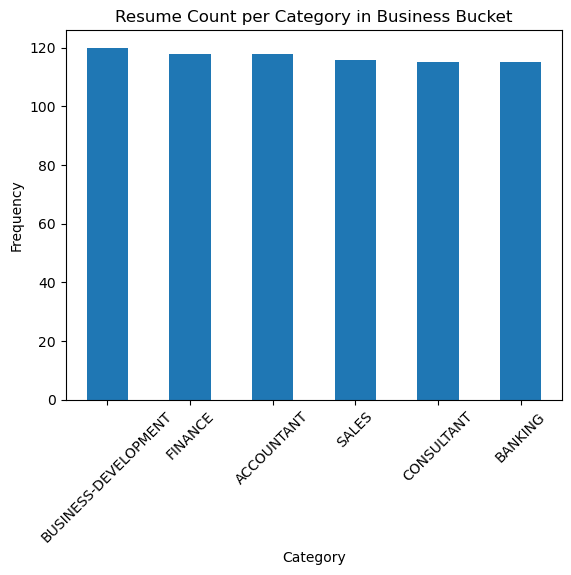

In [25]:
!pip install -q wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

bus_count = df_bus_fin['Category'].value_counts()
bus_count.plot(kind='bar')

plt.title("Resume Count per Category in Business Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

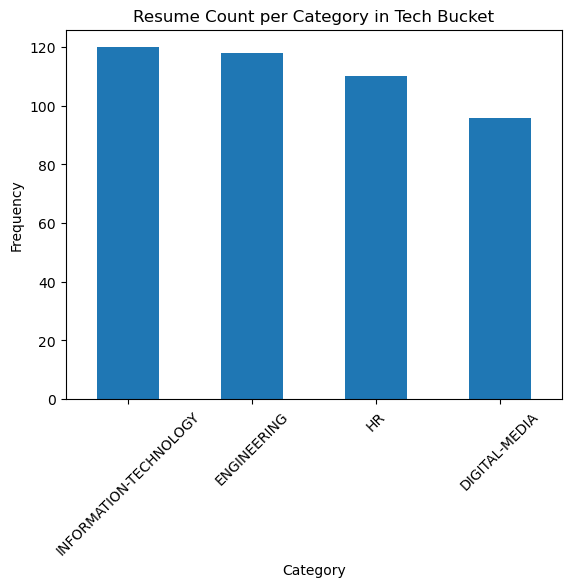

In [27]:
tech_count = df_tech['Category'].value_counts()
tech_count.plot(kind='bar')
plt.title("Resume Count per Category in Tech Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

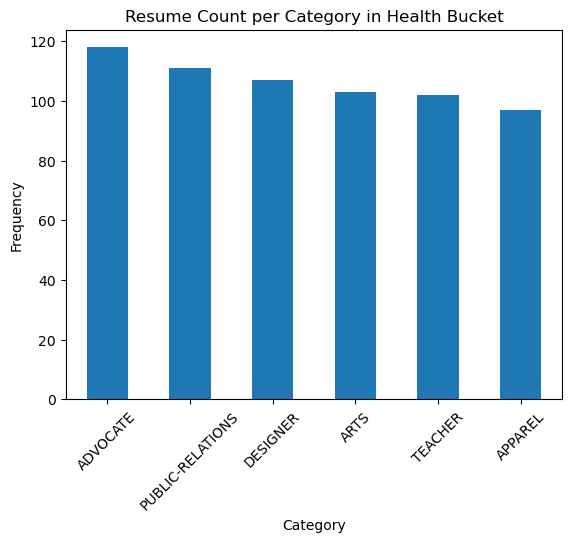

In [35]:
creative_count = df_creative_public['Category'].value_counts()
creative_count.plot(kind='bar')
plt.title("Resume Count per Category in Health Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

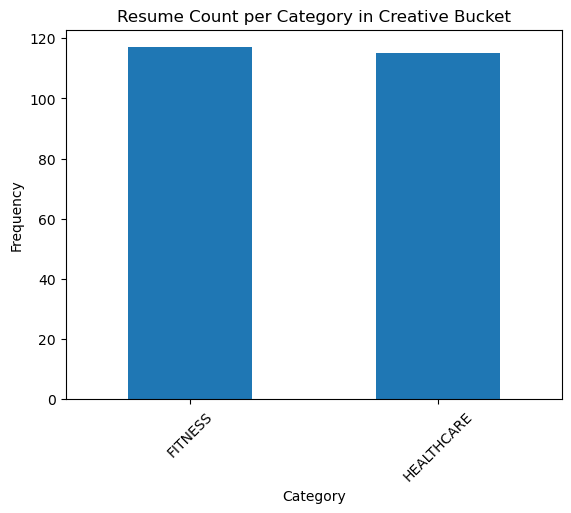

In [33]:
health_count = df_health_well['Category'].value_counts()
health_count.plot(kind='bar')
plt.title("Resume Count per Category in Creative Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

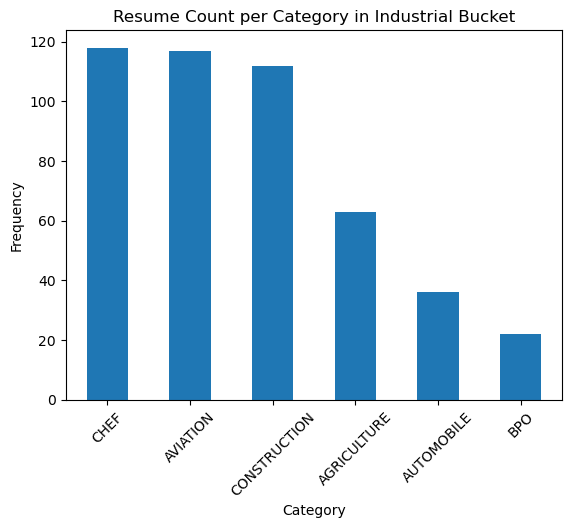

In [29]:
industrial_count = df_indust['Category'].value_counts()
industrial_count.plot(kind='bar')
plt.title("Resume Count per Category in Industrial Bucket")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

Index(['ID', 'Resume_str', 'Category', 'Cleaned_str'], dtype='object')


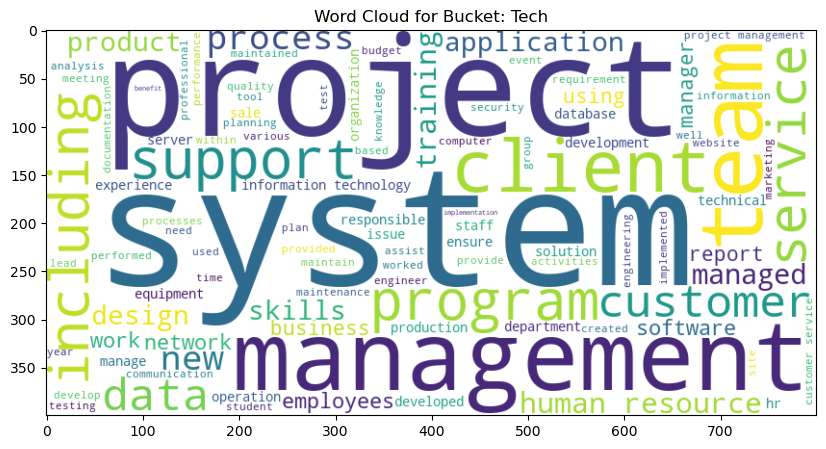

In [81]:
from collections import Counter
print(df_tech.columns)

texts = ' '.join(df_tech["Cleaned_str"].astype(str))

custom_stopwords = set(top5).union({'name', 'city', 'state', 'company', 'employee', 'skill'})

filtered_words = [word for word in words if word not in custom_stopwords]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Bucket: Tech")
plt.show()

In [ ]:
df['resume_length'] = df['Resume_str'].str.count(' ').add(1)
average_length = df.groupby('Category')['resume_length'].mean()

average_length.plot(kind='bar')
plt.title("Avg Resume Length per Category")
plt.xlabel("Category")
plt.ylabel("Average Resume Length")
plt.xticks(rotation=45)
plt.show()

# Tesla Software and Energy Engineer
## 1. First Resume Cleaning Cycle

In [ ]:
# Need to clean here for if they are pursuing a degree in the right area, etc...

In [ ]:
# Load a pre-trained SBERT model (https://sbert.net/)
m_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

# Move to file potentially
tesla_job_desc = (
    "Develop, enhance and debug new and existing real-time software in C/C++ in embedded RTOS environments. "
    "Work with HW and system teams on building testing infrastructure. Help design and bring up state of the art HIL/SIL validation infrastructure. "
    "Help implement software tests for HIL/SIL infrastructure. Assist in tool development for testing and system integration. "
    "Own implementation of software/firmware features end to end. What You'll Bring "
    "Pursuing a Degree in Computer Science, Electrical Engineering, Physics or related field. "
    "Desired to have strong understanding of Python debug simple circuits. "
    "Desired to have good electrical and electronics fundamentals to be able to understand schematics and desired to have test driven development mindset. "
    "Remain engaged, proactive and positive while solving very challenging problems. "
    "Own assignments and take full accountability for overall team success. "
    "Capable of delivering top quality C/C++ code for embedded systems."
)

results = []

def compute_similarity(index):
    resume = df_tech.iloc[index]["Cleaned_str"]
    embed_resume = m_SBERT.encode(resume)
    embed_jobdesc = m_SBERT.encode(tesla_job_desc)
    similarity = cosine_similarity([embed_resume], [embed_jobdesc])[0][0]
    results.append((index, similarity))

for i in range(len(df_tech)):
    compute_similarity(i)

In [ ]:
# If over a similarity threshold, print index and similarity.
for i in range(len(results)):
    if results[i][1] > 0.5:
        print(results[i])

In [13]:
print(df_tech.iloc[438]["Cleaned_str"])

qa engineering team lead career overview eight years of progressive technical experience in quality assurance engineering of computer software in windows environment strong practical and theoretical knowledge of software quality assurance tools and techniques. proven ability to develop system test strategy and methodology full-scale system integration and testing for quality, reliability, functionality and computability. expertise in development of ieee compliant testing documentation key contributor to software development teams supporting the release of many new products and release of several major upgrades to existing products experience in testing large and complex client server database applications multi-platform product delivery experience on pc system. experienced with windows graphical products, networking and or data acquisition software experienced in manual and automated testing working on projects of a diverse scope able to expertise judgment within defined parameters. st

## 2. Second Resume Cleaning Cycle

In [ ]:
# Using TF-IDF and cosine similarity to rank the resumes based on the ideal resume 

## 3. Third Resume Cleaning Cycle & SVM Training

In [ ]:
# Train SVM on synthetic lables